## Setting Up Your Python Environment

In [1]:
# %%capture
# # Install PyTorch
# !pip install torch torchvision torchaudio

# # Install additional dependencies
# !pip install matplotlib pandas pillow tqdm

# # Install package for creating visually distinct colormaps
# !pip install distinctipy

# # Install utility packages
# !pip install cjm_psl_utils cjm_pil_utils cjm_pytorch_utils cjm_torchvision_tfms

## Importing the Required Dependencies

In [2]:
# Import Python Standard Library dependencies
from functools import partial
from pathlib import Path

# Import utility functions
from cjm_pil_utils.core import get_img_files
from cjm_psl_utils.core import download_file, file_extract
from cjm_pytorch_utils.core import tensor_to_pil
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Do not truncate the contents of cells and display all rows and columns
pd.set_option('max_colwidth', None, 'display.max_rows', None, 'display.max_columns', None)

# Import PIL for image manipulation
from PIL import Image

# Import PyTorch dependencies
import torch
from torch.utils.data import Dataset, DataLoader

# Import torchvision dependencies
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.v2  as transforms

# Import tqdm for progress bar
from tqdm.auto import tqdm

## Loading and Exploring the Dataset

### Setting the Directory Paths

In [3]:
# Define path to store datasets
dataset_dir = Path("./Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)

# Creating a Series with the paths and converting it to a DataFrame for display
pd.Series({
    "Dataset Directory:": dataset_dir, 
    "Archive Directory:": archive_dir
}).to_frame().style.hide(axis='columns')

Dataset Directory:,Datasets
Archive Directory:,Datasets/../Archive


### Setting the Dataset Path

In [4]:
# Set the name of the dataset
dataset_name = 'coco-bounding-box-toy-dataset'

# Construct the HuggingFace Hub dataset name by combining the username and dataset name
hf_dataset = f'cj-mills/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')

# Creating a Series with the dataset name and paths and converting it to a DataFrame for display
pd.Series({
    "HuggingFace Dataset:": hf_dataset, 
    "Archive Path:": archive_path, 
    "Dataset Path:": dataset_path
}).to_frame().style.hide(axis='columns')

HuggingFace Dataset:,cj-mills/coco-bounding-box-toy-dataset
Archive Path:,Datasets/../Archive/coco-bounding-box-toy-dataset.zip
Dataset Path:,Datasets/coco-bounding-box-toy-dataset


### Downloading the Dataset

In [5]:
# Construct the HuggingFace Hub dataset URL
dataset_url = f"https://huggingface.co/datasets/{hf_dataset}/resolve/main/{dataset_name}.zip"
print(f"HuggingFace Dataset URL: {dataset_url}")

# Set whether to delete the archive file after extracting the dataset
delete_archive = True

# Download the dataset if not present
if dataset_path.is_dir():
    print("Dataset folder already exists")
else:
    print("Downloading dataset...")
    download_file(dataset_url, archive_dir)    
    
    print("Extracting dataset...")
    file_extract(fname=archive_path, dest=dataset_dir)
    
    # Delete the archive if specified
    if delete_archive: archive_path.unlink()

HuggingFace Dataset URL: https://huggingface.co/datasets/cj-mills/coco-bounding-box-toy-dataset/resolve/main/coco-bounding-box-toy-dataset.zip
Dataset folder already exists


### Getting the Image and Annotation Folders

In [6]:
 # Assuming the images are stored in a subfolder named 'images'
img_dir = dataset_path/'images/'

# Assuming the annotation file is in JSON format and located in a subdirectory of the dataset
annotation_file_path = list(dataset_path.glob('*/*.json'))[0]

# Creating a Series with the paths and converting it to a DataFrame for display
pd.Series({
    "Image Folder": img_dir, 
    "Annotation File": annotation_file_path}).to_frame().style.hide(axis='columns')

Image Folder,Datasets/coco-bounding-box-toy-dataset/images
Annotation File,Datasets/coco-bounding-box-toy-dataset/annotations/instances_default.json


### Get Image File Paths

In [7]:
# Get all image files in the 'img_dir' directory
img_dict = {
    file.stem : file # Create a dictionary that maps file names to file paths
    for file in get_img_files(img_dir) # Get a list of image files in the image directory
}

# Print the number of image files
print(f"Number of Images: {len(img_dict)}")

# Display the first five entries from the dictionary using a Pandas DataFrame
pd.DataFrame.from_dict(img_dict, orient='index').head()

Number of Images: 28


,0
alcoholic-beverage-bar-beer-1269028,Datasets/coco-bounding-box-toy-dataset/images/alcoholic-beverage-bar-beer-1269028.jpg
architectural-design-architecture-asphalt-2445783,Datasets/coco-bounding-box-toy-dataset/images/architectural-design-architecture-asphalt-2445783.jpg
architecture-buildings-cars-1169374,Datasets/coco-bounding-box-toy-dataset/images/architecture-buildings-cars-1169374.jpg
architecture-buildings-commerce-2308592,Datasets/coco-bounding-box-toy-dataset/images/architecture-buildings-commerce-2308592.jpg
architecture-buildings-commuter-2516442,Datasets/coco-bounding-box-toy-dataset/images/architecture-buildings-commuter-2516442.jpg


### Get Image Annotations

#### Load the annotation file into a DataFrame

In [8]:
# Read the JSON file into a DataFrame, assuming the JSON is oriented by index
annotation_file_df = pd.read_json(annotation_file_path, orient='index').transpose()
annotation_file_df.head()

,licenses,info,categories,images,annotations
0,"{'name': '', 'id': 0, 'url': ''}",contributor,"{'id': 1, 'name': 'person', 'supercategory': ''}","{'id': 1, 'width': 768, 'height': 1152, 'file_name': '258421.jpg', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}","{'id': 1, 'image_id': 1, 'category_id': 1, 'segmentation': [], 'area': 24904.862800000003, 'bbox': [386.08, 443.94, 74.74, 333.22], 'iscrowd': 0, 'attributes': {'occluded': False, 'rotation': 0.0}}"
1,None,date_created,None,"{'id': 2, 'width': 1344, 'height': 768, 'file_name': '3075367.jpg', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}","{'id': 2, 'image_id': 1, 'category_id': 1, 'segmentation': [], 'area': 24440.896000000004, 'bbox': [340.25, 466.94, 78.74, 310.4], 'iscrowd': 0, 'attributes': {'occluded': False, 'rotation': 0.0}}"
2,None,description,None,"{'id': 3, 'width': 768, 'height': 1120, 'file_name': '3076319.jpg', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}","{'id': 3, 'image_id': 2, 'category_id': 1, 'segmentation': [], 'area': 365660.4554999999, 'bbox': [413.32, 41.22, 506.49, 721.95], 'iscrowd': 0, 'attributes': {'occluded': False, 'rotation': 0.0}}"
3,None,url,None,"{'id': 4, 'width': 1184, 'height': 768, 'file_name': '3145551.jpg', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}","{'id': 4, 'image_id': 3, 'category_id': 1, 'segmentation': [], 'area': 363031.32340000005, 'bbox': [335.31, 151.75, 375.91, 965.74], 'iscrowd': 0, 'attributes': {'occluded': False, 'rotation': 0.0}}"
4,None,version,None,"{'id': 5, 'width': 1152, 'height': 768, 'file_name': '3176048.jpg', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}","{'id': 5, 'image_id': 3, 'category_id': 1, 'segmentation': [], 'area': 390988.36079999997, 'bbox': [8.11, 131.88, 396.09, 987.12], 'iscrowd': 0, 'attributes': {'occluded': False, 'rotation': 0.0}}"


#### Extract the object classes

In [9]:
# Extract and transform the 'categories' section of the data
# This DataFrame contains category details like category ID and name
categories_df = annotation_file_df['categories'].dropna().apply(pd.Series)
categories_df.set_index('id', inplace=True)
categories_df

,name,supercategory
id,,
1,person,


#### Extract the image information

In [10]:
# Extract and transform the 'images' section of the data
# This DataFrame contains image details like file name, height, width, and image ID
images_df = annotation_file_df['images'].to_frame()['images'].apply(pd.Series)[['file_name', 'height', 'width', 'id']]
images_df.head()

,file_name,height,width,id
0,258421.jpg,1152.0,768.0,1.0
1,3075367.jpg,768.0,1344.0,2.0
2,3076319.jpg,1120.0,768.0,3.0
3,3145551.jpg,768.0,1184.0,4.0
4,3176048.jpg,768.0,1152.0,5.0


#### Extract the annotation information

In [11]:
# Extract and transform the 'annotations' section of the data
# This DataFrame contains annotation details like image ID, bounding box, and category ID
annotations_df = annotation_file_df['annotations'].to_frame()['annotations'].apply(pd.Series)[['image_id', 'bbox', 'category_id']]
annotations_df.head()

,image_id,bbox,category_id
0,1,"[386.08, 443.94, 74.74, 333.22]",1
1,1,"[340.25, 466.94, 78.74, 310.4]",1
2,2,"[413.32, 41.22, 506.49, 721.95]",1
3,3,"[335.31, 151.75, 375.91, 965.74]",1
4,3,"[8.11, 131.88, 396.09, 987.12]",1


#### Add the class names to the annotations

In [12]:
# Map 'category_id' in annotations DataFrame to category name using categories DataFrame
annotations_df['label'] = annotations_df['category_id'].apply(lambda x: categories_df.loc[x]['name'])
annotations_df.head()

,image_id,bbox,category_id,label
0,1,"[386.08, 443.94, 74.74, 333.22]",1,person
1,1,"[340.25, 466.94, 78.74, 310.4]",1,person
2,2,"[413.32, 41.22, 506.49, 721.95]",1,person
3,3,"[335.31, 151.75, 375.91, 965.74]",1,person
4,3,"[8.11, 131.88, 396.09, 987.12]",1,person


#### Merge the image and  annotation information

In [13]:
# Merge annotations DataFrame with images DataFrame on their image ID
annotation_df = pd.merge(annotations_df, images_df, left_on='image_id', right_on='id')
annotation_df.head()

,image_id,bbox,category_id,label,file_name,height,width,id
0,1,"[386.08, 443.94, 74.74, 333.22]",1,person,258421.jpg,1152.0,768.0,1.0
1,1,"[340.25, 466.94, 78.74, 310.4]",1,person,258421.jpg,1152.0,768.0,1.0
2,2,"[413.32, 41.22, 506.49, 721.95]",1,person,3075367.jpg,768.0,1344.0,2.0
3,3,"[335.31, 151.75, 375.91, 965.74]",1,person,3076319.jpg,1120.0,768.0,3.0
4,3,"[8.11, 131.88, 396.09, 987.12]",1,person,3076319.jpg,1120.0,768.0,3.0


#### Use the image name as the index

In [14]:
# Remove old 'id' column post-merge
annotation_df.drop('id', axis=1, inplace=True)

# Extract the image_id from the file_name (assuming file_name contains the image_id)
annotation_df['image_id'] = annotation_df['file_name'].apply(lambda x: x.split('.')[0])

# Set 'image_id' as the index for the DataFrame
annotation_df.set_index('image_id', inplace=True)
annotation_df.head()

,bbox,category_id,label,file_name,height,width
image_id,,,,,,
258421,"[386.08, 443.94, 74.74, 333.22]",1,person,258421.jpg,1152.0,768.0
258421,"[340.25, 466.94, 78.74, 310.4]",1,person,258421.jpg,1152.0,768.0
3075367,"[413.32, 41.22, 506.49, 721.95]",1,person,3075367.jpg,768.0,1344.0
3076319,"[335.31, 151.75, 375.91, 965.74]",1,person,3076319.jpg,1120.0,768.0
3076319,"[8.11, 131.88, 396.09, 987.12]",1,person,3076319.jpg,1120.0,768.0


#### Group annotations by image

In [15]:
# Group the data by 'image_id' and aggregate information
# This results in each image ID having a list of bounding boxes, category IDs, labels, and the respective file name, height, and width
annotation_df = annotation_df.groupby('image_id').agg({'bbox': list, 
                                           'category_id': list,
                                           'label' :list,
                                           'file_name': 'first', 
                                           'height': 'first', 
                                           'width': 'first'
                                                      })

# Rename columns for clarity 
# 'bbox' is renamed to 'bboxes' and 'label' to 'labels'
annotation_df.rename(columns={'bbox': 'bboxes', 'label': 'labels'}, inplace=True)
annotation_df.head()

,bboxes,category_id,labels,file_name,height,width
image_id,,,,,,
258421,"[[386.08, 443.94, 74.74, 333.22], [340.25, 466.94, 78.74, 310.4]]","[1, 1]","[person, person]",258421.jpg,1152.0,768.0
3075367,"[[413.32, 41.22, 506.49, 721.95]]",[1],[person],3075367.jpg,768.0,1344.0
3076319,"[[335.31, 151.75, 375.91, 965.74], [8.11, 131.88, 396.09, 987.12]]","[1, 1]","[person, person]",3076319.jpg,1120.0,768.0
3145551,"[[642.0, 289.85, 27.66, 109.04], [658.63, 281.25, 28.46, 117.36]]","[1, 1]","[person, person]",3145551.jpg,768.0,1184.0
3176048,"[[518.23, 338.97, 76.4, 127.11], [683.42, 356.48, -44.56, 81.34]]","[1, 1]","[person, person]",3176048.jpg,768.0,1152.0


### Inspecting the Class Distribution

#### Get image classes

In [16]:
# Get a list of unique labels in the 'annotation_df' DataFrame
class_names = annotation_df['labels'].explode().unique().tolist()

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names)

,0
0,person


#### Visualize the class distribution

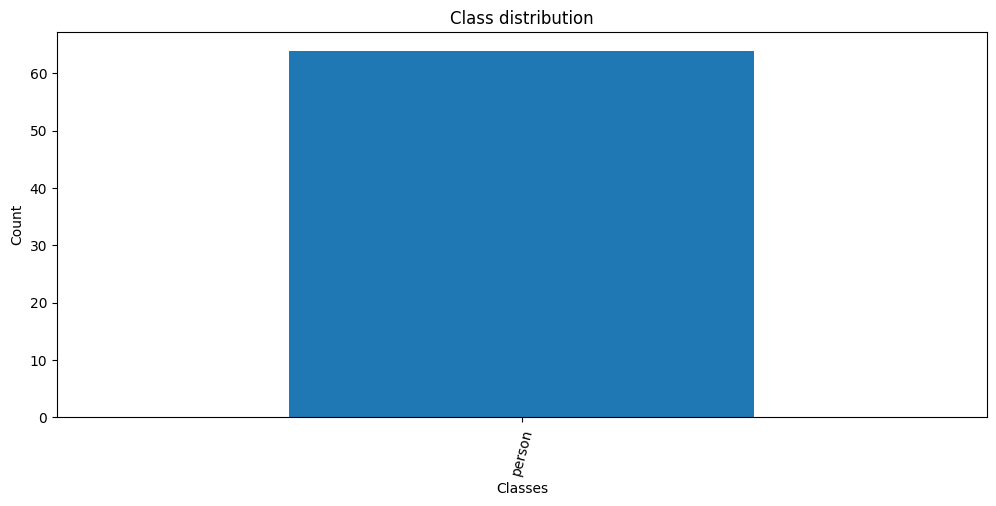

In [17]:
# Get the number of samples for each object class
class_counts = pd.DataFrame(annotation_df['labels'].explode().tolist()).value_counts()

plot_labels = [index[0] for index in class_counts.index]

# Plot the distribution
class_counts.plot(kind='bar', figsize=(12, 5))
plt.title('Class distribution')
plt.ylabel('Count')
plt.xlabel('Classes')
plt.xticks(range(len(class_counts.index)), plot_labels, rotation=75)  # Set the x-axis tick labels
plt.show()

### Visualizing Image Annotations

#### Generate a color map

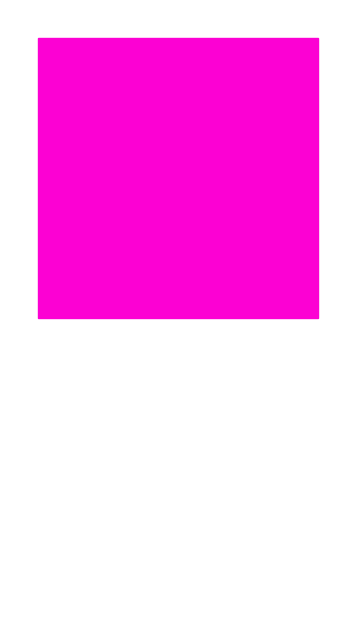

In [18]:
# Generate a list of colors with a length equal to the number of labels
colors = distinctipy.get_colors(len(class_names))

# Make a copy of the color map in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colors]

# Generate a color swatch to visualize the color map
distinctipy.color_swatch(colors)

#### Download a font file

In [19]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


#### Define the bounding box annotation function

In [20]:
draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2, font=font_file, font_size=25)

### Selecting a Sample Image

#### Load the sample image

Image Dims: (1120, 768)


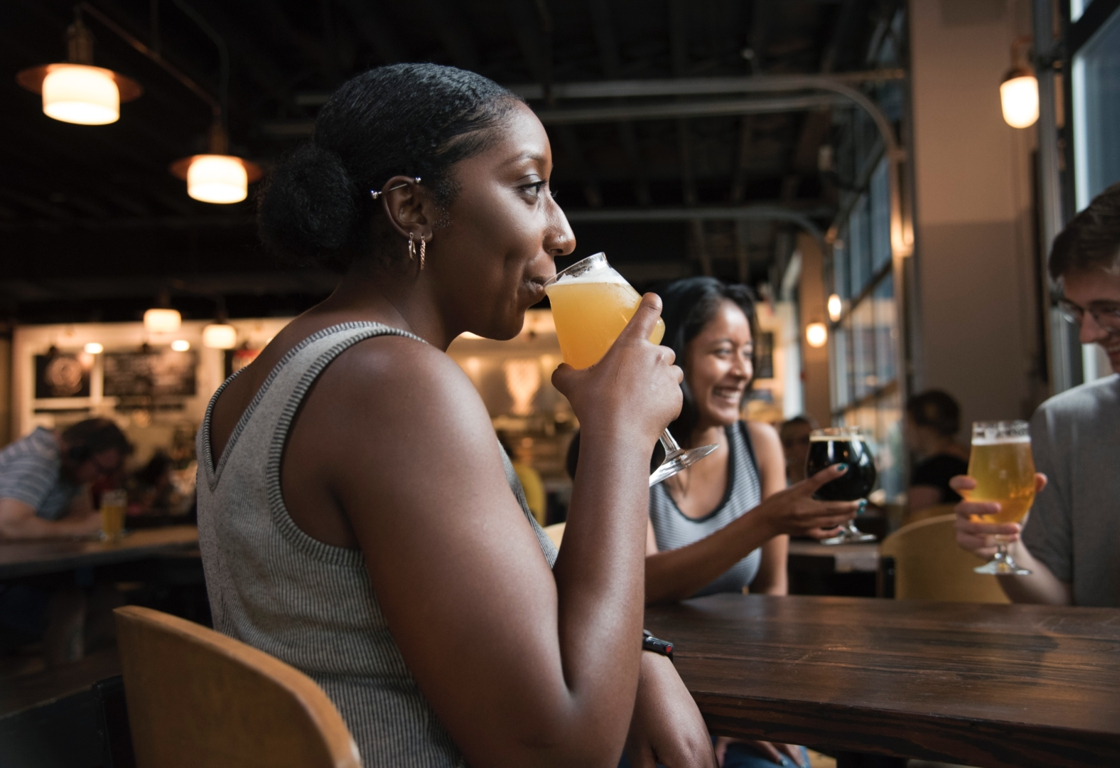

In [21]:
# Get the file ID of the first image file
file_id = list(img_dict.keys())[0]

# Open the associated image file as a RGB image
sample_img = Image.open(img_dict[file_id]).convert('RGB')

# Print the dimensions of the image
print(f"Image Dims: {sample_img.size}")

# Show the image
sample_img

#### Inspect the corresponding annotation data

In [22]:
# Get the row from the 'annotation_df' DataFrame corresponding to the 'file_id'
annotation_df.loc[file_id].to_frame()

,alcoholic-beverage-bar-beer-1269028
bboxes,"[[567.93, 278.21, 300.61, 317.07], [191.38, 59.88, 528.78, 703.37], [947.8, 178.82, 171.2, 428.29]]"
category_id,"[1, 1, 1]"
labels,"[person, person, person]"
file_name,alcoholic-beverage-bar-beer-1269028.jpg
height,768.0
width,1120.0


#### Annotate sample image

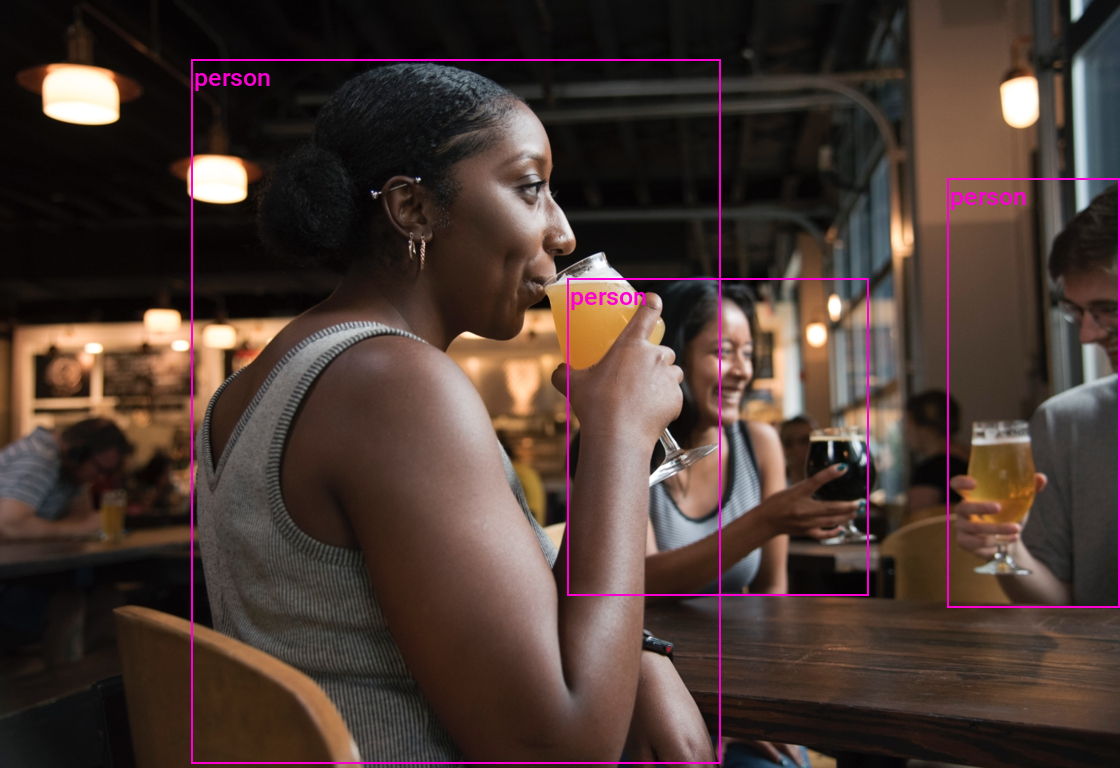

In [23]:
# Extract the labels and bounding box annotations for the sample image
labels = annotation_df.loc[file_id]['labels']
bboxes = annotation_df.loc[file_id]['bboxes']

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=transforms.PILToTensor()(sample_img), 
    boxes=torchvision.ops.box_convert(torch.Tensor(bboxes), 'xywh', 'xyxy'),
    labels=labels, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

tensor_to_pil(annotated_tensor)

## Preparing the Data

### Data Augmentation

#### Set training image size

In [24]:
# Set training image size
train_sz = 384

#### Initialize custom transforms

In [25]:
# Create a RandomIoUCrop object
iou_crop = CustomRandomIoUCrop(min_scale=0.3, 
                               max_scale=1.0, 
                               min_aspect_ratio=0.5, 
                               max_aspect_ratio=2.0, 
                               sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                               trials=400, 
                               jitter_factor=0.25)

# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=train_sz)

# Create a `PadSquare` object
pad_square = PadSquare(shift=True)

#### Test the transforms

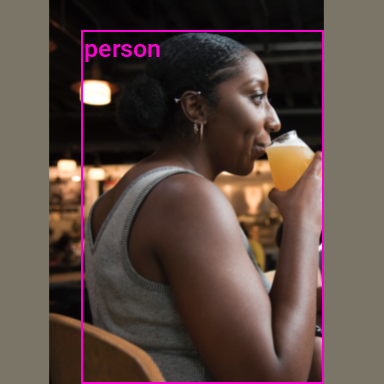

Source Image:,"(1120, 768)"
Cropped Image:,"(531, 743)"
Resized Image:,"(274, 383)"
Padded Image:,"(383, 383)"
Resized Padded Image:,"(384, 384)"


In [26]:
# Prepare bounding box targets
targets = {
    'boxes': BoundingBoxes(torchvision.ops.box_convert(torch.Tensor(bboxes), 'xywh', 'xyxy'), 
                           format='xyxy', 
                           canvas_size=sample_img.size[::-1]), 
    'labels': torch.Tensor([class_names.index(label) for label in labels])
}

# Crop the image
cropped_img, targets = iou_crop(sample_img, targets)

# Resize the image
resized_img, targets = resize_max(cropped_img, targets)

# Pad the image
padded_img, targets = pad_square(resized_img, targets)

# Ensure the padded image is the target size
resize = transforms.Resize([train_sz] * 2, antialias=True)
resized_padded_img, targets = resize(padded_img, targets)
sanitized_img, targets = transforms.SanitizeBoundingBoxes()(resized_padded_img, targets)

# Annotate the augmented image with updated labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=transforms.PILToTensor()(sanitized_img), 
    boxes=targets['boxes'], 
    labels=[class_names[int(label.item())] for label in targets['labels']], 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

# Display the annotated image
display(tensor_to_pil(annotated_tensor))

pd.Series({
    "Source Image:": sample_img.size,
    "Cropped Image:": cropped_img.size,
    "Resized Image:": resized_img.size,
    "Padded Image:": padded_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')

### Training Dataset Class

In [27]:
class COCOBBoxDataset(Dataset):
    """
    A dataset class for COCO-style datasets with bounding box annotations.

    This class is designed to handle datasets where images are annotated with bounding boxes,
    such as object detection tasks. It supports loading images, applying transformations, 
    and retrieving the associated bounding box annotations.

    Attributes:
        _img_keys (list): A list of keys (identifiers) for each image in the dataset.
        _annotation_df (DataFrame): A DataFrame containing annotations for the images. 
                                    Each row corresponds to an image, indexed by its key.
        _img_dict (dict): A dictionary mapping image keys to their file paths.
        _class_to_idx (dict): A dictionary mapping class names to their corresponding indices.
        _transforms (callable, optional): Optional transform to be applied on a sample.

    Methods:
        __len__: Returns the number of images in the dataset.
        __getitem__: Retrieves an image and its corresponding target (bounding boxes and labels) 
                     by index.
        _load_image_and_target: Helper function to load an image and its corresponding target.
    """

    def __init__(self, img_keys, annotation_df, img_dict, class_to_idx, transforms=None):
        """
        Initializes the COCOBBoxDataset instance.

        Parameters:
            img_keys (list): List of image keys.
            annotation_df (DataFrame): DataFrame containing image annotations.
            img_dict (dict): Dictionary mapping image keys to file paths.
            class_to_idx (dict): Dictionary mapping class names to indices.
            transforms (callable, optional): Optional transform to be applied on a sample.
        """
        super(Dataset, self).__init__()
        
        self._img_keys = img_keys  # List of image keys
        self._annotation_df = annotation_df  # DataFrame containing annotations
        self._img_dict = img_dict  # Dictionary mapping image keys to image paths
        self._class_to_idx = class_to_idx  # Dictionary mapping class names to class indices
        self._transforms = transforms  # Image transforms to be applied
        
    def __len__(self):
        """
        Returns the total number of images in the dataset.

        Returns:
            int: The number of images in the dataset.
        """
        return len(self._img_keys)
        
    def __getitem__(self, index):
        """
        Retrieves an image and its corresponding target (bounding boxes and labels) by index.

        Parameters:
            index (int): The index of the image in the dataset.

        Returns:
            tuple: A tuple containing the image and its target. The target is a dictionary with 
                   keys 'boxes' and 'labels'.
        """
        img_key = self._img_keys[index]
        annotation = self._annotation_df.loc[img_key]
        image, target = self._load_image_and_target(annotation)
        
        if self._transforms:
            # Apply the specified transformations to the image and target
            image, target = self._transforms(image, target)
        
        return image, target

    def _load_image_and_target(self, annotation):
        """
        Helper function to load an image and its corresponding target.

        The target includes bounding boxes and labels for the image.

        Parameters:
            annotation (pandas.Series): The annotation data for the image, typically a row from the DataFrame.

        Returns:
            tuple: A tuple containing the image and its target, where the target is a dictionary 
                   with keys 'boxes' and 'labels'.
        """
        # Load the image file using the path from the image dictionary
        filepath = self._img_dict[annotation.name]
        image = Image.open(filepath).convert('RGB')

        # Extract bounding box data from the annotations and convert to the desired format
        bbox_list = annotation['bboxes']
        bbox_tensor = torchvision.ops.box_convert(torch.Tensor(bbox_list), 'xywh', 'xyxy')
        boxes = BoundingBoxes(bbox_tensor, format='xyxy', canvas_size=image.size[::-1])

        # Convert class labels in the annotation to their corresponding indices
        annotation_labels = annotation['labels']
        labels = torch.Tensor([self._class_to_idx[label] for label in annotation_labels])

        return image, {'boxes': boxes, 'labels': labels}

### Image Transforms

In [28]:
# Compose transforms for data augmentation
data_aug_tfms = transforms.Compose(
    transforms=[
        iou_crop,
        transforms.ColorJitter(
                brightness = (0.875, 1.125),
                contrast = (0.5, 1.5),
                saturation = (0.5, 1.5),
                hue = (-0.05, 0.05),
        ),
        transforms.RandomGrayscale(),
        transforms.RandomEqualize(),
        transforms.RandomPosterize(bits=3, p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
    ],
)

# Compose transforms to resize and pad input images
resize_pad_tfm = transforms.Compose([
    resize_max, 
    pad_square,
    transforms.Resize([train_sz] * 2, antialias=True)
])

# Compose transforms to sanitize bounding boxes and normalize input data
final_tfms = transforms.Compose([
    transforms.ToImage(), 
    transforms.ToDtype(torch.float32, scale=True),
    transforms.SanitizeBoundingBoxes(),
])

# Define the transformations for training and validation datasets
train_tfms = transforms.Compose([
    data_aug_tfms, 
    resize_pad_tfm, 
    final_tfms
])

### Initialize Dataset

In [29]:
# Create a mapping from class names to class indices
class_to_idx = {c: i for i, c in enumerate(class_names)}

# Instantiate the dataset using the defined transformations
train_dataset = COCOBBoxDataset(list(img_dict.keys()), annotation_df, img_dict, class_to_idx, train_tfms)

# Print the number of samples in the training dataset
pd.Series({
    'Training dataset size:': len(train_dataset),
}).to_frame().style.hide(axis='columns')

Training dataset size:,28


### Inspect Samples

#### Inspect training set sample

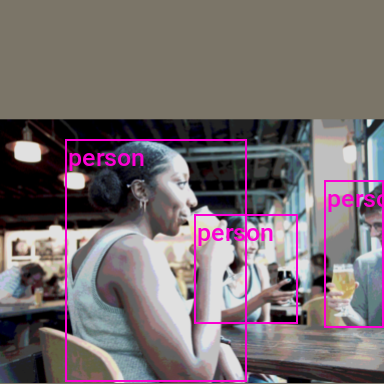

In [30]:
dataset_sample = train_dataset[0]

annotated_tensor = draw_bboxes(
    image=(dataset_sample[0]*255).to(dtype=torch.uint8), 
    boxes=dataset_sample[1]['boxes'], 
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']], 
    colors=[int_colors[int(i.item())] for i in dataset_sample[1]['labels']]
)

tensor_to_pil(annotated_tensor)